# Introduction to Graph Neural Networks

In this notebook, we will see a practical example of how to address the problem of node classification using **Graph Neural Networks (GNNs)**.

## Preliminaries

We denote by $G\left\langle V, E \right\rangle$ the graph with nodes in $V$ connected by edges in $E$, and we let $N=|V|$ be the number of nodes. We represent the edge from node $u_i$ to node $u_j$, as the tuple $(u_i, u_j)$. To account for (optional) edge weights, we represent the graph connectivity also by means of the **adjacency matrix** $\mathbf{A} \in \mathbb{R}^{N \times N}$, whose element $a_{ij}$ is the weight of the edge $(u_i, u_j)$, with $a_{ij} = 0$ if $(u_i, u_j) \not\in E$. We denote by $\textbf{X} \in \mathbb{R}^{N \times d_x}$ the **node-attribute matrix** containing information about the nodes.

### Graph Neural Network

We call **Graph Neural Network (GNN)** a generic neural network featuring (a stack of) parametric layers taking as input a graph connectivity. **Graph convolutions** are an example of such layers. In the following, we denote by $\mathbf{H}^l \in \mathbb{R}^{N \times d^l_h}$ the node features at the $l$-th layer of the network. A simple recipe for graph convolutions is the following:

$$\mathbf{H}^{l+1} = \sigma\left(\mathbf{\tilde{A}}\mathbf{H}^{l}\boldsymbol{\Theta}^l \right) , \tag{1}$$

where $\boldsymbol{\Theta}^l \in \mathbb{R}^{d_h^l \times d_h^{l+1}}$ is a learnable parameter matrix and $\sigma$ is a nonlinear activation function. The matrix $\mathbf{\tilde{A}} \in \mathbb{R}^{N \times N}$ is a **Graph Shift Operator**, i.e., an $N \times N$ matrix such that

$$\widetilde{a}_{ij} = 0 \text{ for } (i, j) \not\in E \text{ and } i \ne j.$$

A more expressive way to represent and build graph-powered layers is through the **message-passing** paradigm.

### Message passing

The message-passing equation is the following:

$$\DeclareMathOperator*{\aggr}{\texttt{Aggr}}
\mathbf{h}^{l+1}_i =\gamma^l_{\theta} \left( \mathbf{h}^l_i, \aggr_{j \in N(i)} \left\{ \phi^l_{\theta} \left(\mathbf{h}^l_i, \mathbf{h}^l_j\right) \right\} \right)  \tag{2}$$

where $N(i)$ is the set of neighbors of the $i$-th node, $\phi^l_{\theta}$ and $\gamma^l_{\theta}$ are called **message** and **update functions** and are generic, differentiable, nonlinear functions (e.g., MLPs), and $\texttt{Aggr}$ is a permutation invariant, differentiable
function (e.g., sum or mean) called **aggregation function**.

## Introduction to Pytorch Geometric

In the following, we will see how to practically implement Graph Neural Networks in Python using the [PyTorch](https://pytorch.org/) framework. We will use **[PyTorch Geometric (PyG)](https://github.com/pyg-team/pytorch_geometric)**, a comprehensive and widely used python library for designing Graph Neural Networks built on top of PyTorch.

Let's start by installing the library (plus the dependencies) and adding helper functions for the downstream example.

In [1]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE


def visualize(h, color):
    z = TSNE(n_components=2, learning_rate='auto',
             init='random').fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

def print_model_size(model):
    tot = sum([p.numel() for p in model.parameters() if p.requires_grad])
    out = f"Number of model ({model.__class__.__name__}) parameters:{tot:10d}"
    print("=" * len(out))
    print(out)

2.1.0+cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 17.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


We focus on the task of **node classification**. Given a graph $G$ in which only a subset of nodes $S \subset V$ is labeled, the goal is to infer the label of all the unlabelled nodes $U = V \setminus S$. This problem lies in the family of problems known as **transductive learning**, in which predictions are made only for nodes and graphs observed at training time.

In this example, we will use the **`Cora`** dataset, a popular dataset in the `Planetoid` benchmark suite [(Yang et al., 2016)](https://arxiv.org/abs/1603.08861). This dataset is a **citation network**, i.e., a graph where nodes represent documents and two nodes are connected if there is at least a citation link between the two related documents. Each node $u_i$ is then associated with:

* a feature vector $\mathbf{x}_i \in \mathbb{R}^{d_x}$, with $d_x = 1433$, representing a bag-of-words of the document;
* if $u_i \in S$, a label $y_i \in \{0, \ldots, 6\}$, representing the category of the document (7 in total).

This dataset is provided by PyTorch Geometric via the [`torch_geometric.datasets`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets) module and can be instantiated easily as:

In [2]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print(f'Dataset: {dataset}')
print('========================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Processing...


Dataset: Cora()
Number of graphs: 1
Number of features: 1433
Number of classes: 7


Done!


This dataset is a subclass of [`torch_geometric.data.InMemoryDataset`](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.data.InMemoryDataset.html), a useful API to build graph-based datasets ready-to-work with PyTorch and PyG. In principle, an `InMemoryDataset` is a collection of attributed graphs, each with its set of features and labels for supervised learning tasks.

In our case, we can see that the `Cora` dataset holds exactly **one graph** (the citation network), the node-feature vector has **1433 dimensions** (the bag-of-words) and there are **7 classes** (the documents' categories). Notice that we used `transform=NormalizeFeatures()` to [row-normalize](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.NormalizeFeatures) the input feature vectors. [Data transformations](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#data-transforms) can be used to modify `Data` objects before feeding them into the model.

The graphs in the dataset can be accessed similarly to the elements of a list in Python:

In [3]:
data = dataset[0]  # Get the first graph object.

print(data)

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


A graph in PyG is represented by the [`Data`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data) object, containing all the information related to the graph.

From the data summary, we can see that the `Cora` graph has 6 attributes:

1. `data.x`: the **node features** with shape `[num_nodes, num_features]`;
1. `data.edge_index`: the **graph connectivity**, i.e., a tuple of source and target node indices for each edge;
1. `data.y`: the **node labels** (one class for each node).

Moreover, the graph object comes with three boolean masks specifying for each node whether it is used for training (`data.train_mask`), validation (`data.val_mask`) or testing (`data.test_mask`).

The `Data` object provides also APIs to some properties and statistics of the underlying graph.

In [4]:
# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')

print('==============================')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print(f'Is weighted: {data.edge_weight is not None}')

print('==============================')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')

Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Has isolated nodes: False
Has self-loops: False
Is undirected: True
Is weighted: False
Number of training nodes: 140
Training node label rate: 0.05


For example, we can check if there are isolated nodes (i.e., nodes with no edges attached) or self-loops (i.e., edges between the same node), or whether the graph is undirected (i.e., $(u_i, u_j) \in E \implies (u_j, u_i) \in E$) or weighted.

For training this dataset, we are given the ground-truth categories of 140 nodes (20 for each class).
This results in a training node label rate of only 5%.

## A first, simple, deep approach

If we discard the *relational information*, we can treat our input data as simple tensors and the node classification problem becomes a standard classification task that can be solved with a simple neural network, e.g., a Multi-layer Perceptron (MLP). We only need to train the parameters $\boldsymbol{\theta}$ of the model $$\widehat{y}_i = f_{\boldsymbol{\theta}}(\mathbf{x}_i) \tag{3}$$ on the labeled nodes in the training set.

In the following, we model $f_{\boldsymbol{\theta}}$ as a simple 2-layer feed-forward neural network.

In [5]:
import torch
from torch.nn import Linear, ReLU, Dropout, Sequential
import torch.nn.functional as F

HIDDEN_SIZE = 16 #@param
NUM_LAYERS = 1 #@param
DROPOUT = 0.1 #@param

class MLP(torch.nn.Module):
    def __init__(self, hidden_size: int,
                 num_layers: int = 1,
                 dropout: float = 0.1):
        super().__init__()
        torch.manual_seed(12345)
        self.dropout = dropout

        layers = []
        for l in range(num_layers):
          in_size = dataset.num_features if l == 0 else hidden_size
          layers.append(Linear(in_size, hidden_size))
          layers.append(ReLU())
          layers.append(Dropout(self.dropout))
        self.mlp = Sequential(*layers)

        self.lin_out = Linear(hidden_size, dataset.num_classes)

    def forward(self, x):
        x = self.mlp(x)
        x = self.lin_out(x)
        return x

model = MLP(HIDDEN_SIZE, NUM_LAYERS, DROPOUT)
print(model)
print_model_size(model)

MLP(
  (mlp): Sequential(
    (0): Linear(in_features=1433, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
  )
  (lin_out): Linear(in_features=16, out_features=7, bias=True)
)
Number of model (MLP) parameters:     23063


We train the model using Adam [(Kingma and Ba, 2015)](https://arxiv.org/abs/1412.6980) optimizer and cross-entropy loss function for 200 epochs. Notice that, since our dataset has only one sample (i.e., the citation network), the number of epochs corresponds to the number of updates. During training, we also evaluate the model performance on the nodes left out for validation.

In [6]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 100})'''))

model = MLP(HIDDEN_SIZE, NUM_LAYERS, DROPOUT)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(),
                             lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 201):
    train_loss = train()
    val_loss = test(data.val_mask)
    print(f'Epoch: {epoch:03d} - Training loss: {train_loss:.4f} - '
          f'Validation accuracy: {val_loss * 100:.2f}%')

<IPython.core.display.Javascript object>

Epoch: 001 - Training loss: 1.9616 - Validation accuracy: 11.60%
Epoch: 002 - Training loss: 1.9544 - Validation accuracy: 13.20%
Epoch: 003 - Training loss: 1.9463 - Validation accuracy: 13.00%
Epoch: 004 - Training loss: 1.9375 - Validation accuracy: 10.00%
Epoch: 005 - Training loss: 1.9258 - Validation accuracy: 9.60%
Epoch: 006 - Training loss: 1.9180 - Validation accuracy: 9.20%
Epoch: 007 - Training loss: 1.9047 - Validation accuracy: 11.00%
Epoch: 008 - Training loss: 1.8937 - Validation accuracy: 19.60%
Epoch: 009 - Training loss: 1.8812 - Validation accuracy: 23.00%
Epoch: 010 - Training loss: 1.8641 - Validation accuracy: 24.40%
Epoch: 011 - Training loss: 1.8519 - Validation accuracy: 25.20%
Epoch: 012 - Training loss: 1.8360 - Validation accuracy: 26.40%
Epoch: 013 - Training loss: 1.8197 - Validation accuracy: 27.60%
Epoch: 014 - Training loss: 1.8026 - Validation accuracy: 29.80%
Epoch: 015 - Training loss: 1.7841 - Validation accuracy: 36.80%
Epoch: 016 - Training loss:

Finally, we test the learned model on the test examples to assess the inference accuracy.

In [7]:
test_acc = test(data.test_mask)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

Test Accuracy: 60.60%


Our trained MLP obtain a $\sim 60\%$ accuracy, meaning that we correctly classify a document only 6 times out of 10. Just to consider a simple baseline, the random assignment would give an accuracy of $1/7 \cdot 100\% = 14.29\%$.
Let's now inspect the output of our MLP. We make use of [**t-SNE**](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to embed our 7-dimensional node embeddings (the model output) onto a 2D plane.

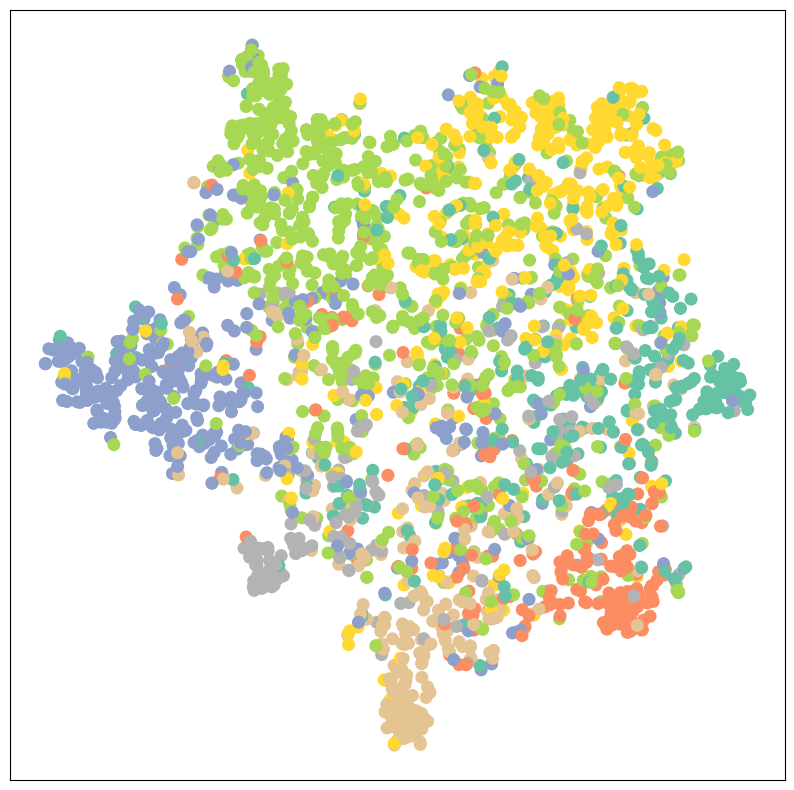

In [8]:
out = model(data.x)
visualize(out, color=data.y)

Can we improve our results? How?

**Idea:** cited papers are likely to lie in the same category as the citing paper. We should embed this information in the learning system as an *inductive bias*.

## Adding relational inductive biases

Eq. 3 shows us one of the limits of our MLP: we are building a classifier for the documents that takes as input only the document's bag-of-words. What we want to do instead, is to consider also **related documents** in the decision process, i.e., we want to learn a parametric model for:
$$\widehat{y}_i = g_{\boldsymbol{\theta}}(\mathbf{X}, \mathbf{A}). \tag{4}$$

For this purpose, we make use of GNNs. In particular, we will build our custom message-passing operation to exploit the **relational inductive biases** in the model. We consider a simple graph convolution described as

$$\mathbf{H}^{l+1} = \text{tanh}\left(\mathbf{H}^l\boldsymbol{\Theta}^l_2 + \mathbf{\tilde{A}}\mathbf{H}^{l}\boldsymbol{\Theta}^l_1 + \boldsymbol{1}_N \mathbf{b}^l \right) \tag{5}$$

where $\mathbf{\tilde{A}}$ is the graph shift operator used and $\boldsymbol{\Theta}^l_1, \boldsymbol{\Theta}^l_2 \in \mathbb{R}^{d_h \times d_h}, \mathbf{b}^l \in \mathbb{R}^{d_h}$ are learnable parameters. We will use the **random-walk matrix** $\mathbf{\tilde{A}} = \mathbf{D}^{-1}\mathbf{A}$ as the reference graph shift operator.

Remember that we can always rewrite graph convolutions of this type by means of the message-passing equation (Eq. 2). For Eq. 5, we implement the three core functions as:

* **message function** $$\mathbf{m}^l_{j \rightarrow i} = \phi^l_{\theta_1} \left(\mathbf{h}^l_j\right) = \mathbf{h}_j^l\boldsymbol{\Theta}^l_1$$

* **aggregate function** $$\mathbf{m}^l_i = \sum_{j \in N(i)} \widetilde{a}_{ji} \cdot \mathbf{m}^l_{j \rightarrow i}$$

* **update function** $$\mathbf{h}^{l+1}_i = \gamma^l_{\theta_2} \left(\mathbf{h}^l_i, \mathbf{m}^l_i\right) = \text{tanh}\left(\mathbf{h}_i^l\boldsymbol{\Theta}^l_2 + \mathbf{m}^l_i + \mathbf{b}^l \right)$$

where $\mathbf{m}^l_{j \rightarrow i}, \mathbf{m}^l_i, \mathbf{h}^{l+1}_i \in  \mathbb{R}^{d_h}$ are the output edge- and node-attribute vectors of the three functions. Notice that the message function does not depend on the features of the receiver node, therefore it can be computed as $\phi^l_{\theta_1} \left(\mathbf{H}^l\right) = \mathbf{H}^l\boldsymbol{\Theta_1}$. Message-passing operators with message function satisfying this property are called **isotropic**.

Putting all together, the node-level graph convolution equation can be written as:

$$\mathbf{h}^{l+1}_i = \text{tanh}\left( \mathbf{h}_i^l\boldsymbol{\Theta}^l_2 + \sum_{j \in N(i)} \widetilde{a}_{ji} \cdot \mathbf{h}_j^l\boldsymbol{\Theta}^l_1 \right) . \tag{6}$$

## Building message-passing layers with PyG

PyTorch Geometric offers a simple API to implement custom PyTorch-ready message-passing layers. We will create a layer implementing Eq. 6 by inheriting from [`torch_geometric.nn.MessagePassing`](https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_gnn.html).

The `MessagePassing` base class allows us to create message-passing graph neural networks by handling message propagation automatically. This is done through methods and attributes of the class that ease the code implementation of the message-passing inner functions:

* When we initialize a class inheriting from `MessagePassing` we need to initialize the parent class with the `super(...)` call. The base `MessagePassing` class has important arguments that we can specify to manipulate the message propagation/aggregation logic:
  
  * `aggr="add"` defines the aggregation scheme to use (`"add"`, `"mean"` or `"max"`);
  * `flow="source_to_target"` defines the flow direction of message passing (either `"source_to_target"` or `"target_to_source"`);
  * `node_dim=-2` defines along which axis to propagate the messages (i.e., the dimension of the nodes in the input tensor).

  The default is `MessagePassing(aggr="add", flow="source_to_target", node_dim=-2)`.

* The method `MessagePassing.propagate(edge_index, size=None, **kwargs)` is in charge of starting messages propagation and is called inside the `forward()` function. It takes as input the `edge_index` (i.e., the graph connectivity) and all additional data needed to build the messages as keyword arguments. The `size` argument can be used to exchange messages in generic (sparse) assignment matrices of shape `[N, M]` by passing `size=(N, M)`. If `size=None`, `edge_index` is assumed to represent a square matrix (e.g., the adjacency matrix).

* Our message function will be inside the `MessagePassing.message(...)` method. It *can* take any argument which was initially passed to `propagate()`. Also, tensors passed to `propagate()` can be mapped to receiver and sender nodes by appending `_i` or `_j` to the variable name, e.g. `x_i` and `x_j`, respectively. Note that `_i` represents the central nodes that aggregate information and `_j` are the neighboring nodes when `flow="source_to_target"` (default).

* The update function can be either implemented using the `MessagePassing.update(aggr_out, ...)` method or simply inside the `forward()` function after `propagate()` (we'll go for the second choice). The `update()` function takes as the first argument the output of aggregation and then any argument initially passed to `propagate()`.

Let's get our hands dirty! We now implement our Message-Passing Neural Network (**`MPNN`**) using the `MessagePassing` class.

In [9]:
import torch

from torch.nn import Linear
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import degree


def random_walk_matrix(edge_index, num_nodes: int = None):
    source, target = edge_index[0], edge_index[1]
    in_deg = degree(target, num_nodes=num_nodes)   # D
    edge_weight = 1 / in_deg[target]               # D^-1 A
    return edge_index, edge_weight


class MPNN(MessagePassing):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__(aggr="add")                         # "sum" aggregation
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.lin_message = Linear(in_channels, out_channels, # weights 𝚯_1
                                  bias=False)
        self.lin_update = Linear(in_channels, out_channels,  # weights 𝚯_2
                                 bias=True)                  # the bias vector 𝐛

    def forward(self, x, edge_index, edge_weight=None):
        # 0. if GSO not already computed, compute it here
        if edge_weight is None:
          _, edge_weight = random_walk_matrix(edge_index)
        # 1. m_j→𝑖 = x_j𝚯_1
        m_ji = self.lin_message(x)  # we can project here with isotropic GNNs
        # 2. m_𝑖 = add(ã_ji ⋅ m_j→𝑖)_j∈𝑁(i)
        m_i = self.propagate(edge_index, m=m_ji, edge_weight=edge_weight)
        # 3. h_𝑖 = tanh(x_i𝚯_2 + m_i + 𝐛)
        h_i = torch.tanh(self.lin_update(x) + m_i)
        return h_i

    def message(self, m_j, edge_weight):
        # m_j has shape [num_edges, num_features]
        return edge_weight.view(-1, 1) * m_j  # ã_ji ⋅ m_j→𝑖


We created our custom message-passing layer, which will serve as the building block for our GNN! We now create a model making use of this layer for the node classification task. For the sake of simplicity, we build a simple, shallow model featuring:

* a **stack** of message-passing layers;
* a linear **decoder**.

Since the considered dataset has only one graph, we can precompute the GSO (i.e., the random walk matrix) and give it as input to the model.

In [10]:
gso_index, gso_weight = random_walk_matrix(data.edge_index, data.num_nodes)
print(f"Edge weights: {gso_weight}")

Edge weights: tensor([0.3333, 0.3333, 0.3333,  ..., 0.2500, 0.2500, 0.2500])


Now it is time to put it all together and build our GNN classifier!

In [11]:
import torch

from torch.nn import Linear

HIDDEN_SIZE = 16 #@param
NUM_LAYERS = 2 #@param

class GNNModel(torch.nn.Module):

    def __init__(self, hidden_size: int,
                 num_layers: int = 1):
        super().__init__()
        torch.manual_seed(12345)

        self.mpnns = torch.nn.ModuleList()
        for l in range(num_layers):
            in_size = dataset.num_features if l == 0 else hidden_size
            mpnn = MPNN(in_channels=in_size, out_channels=hidden_size)
            self.mpnns.append(mpnn)

        self.lin_out = Linear(hidden_size, dataset.num_classes)

    def forward(self, x, edge_index, edge_weight=None):
        # Message-passing: transform node features based on neighbors
        for mpnn in self.mpnns:
            x = mpnn(x, edge_index, edge_weight)

        # Decoder: post-process extracted features
        out = self.lin_out(x)
        return out

model = GNNModel(HIDDEN_SIZE, NUM_LAYERS)
print(model)
print_model_size(model)

GNNModel(
  (mpnns): ModuleList(
    (0): MPNN(1433, 16)
    (1): MPNN(16, 16)
  )
  (lin_out): Linear(in_features=16, out_features=7, bias=True)
)
Number of model (GNNModel) parameters:     46519


Let's now inspect the output of our **untrained** GNN using **t-SNE**:

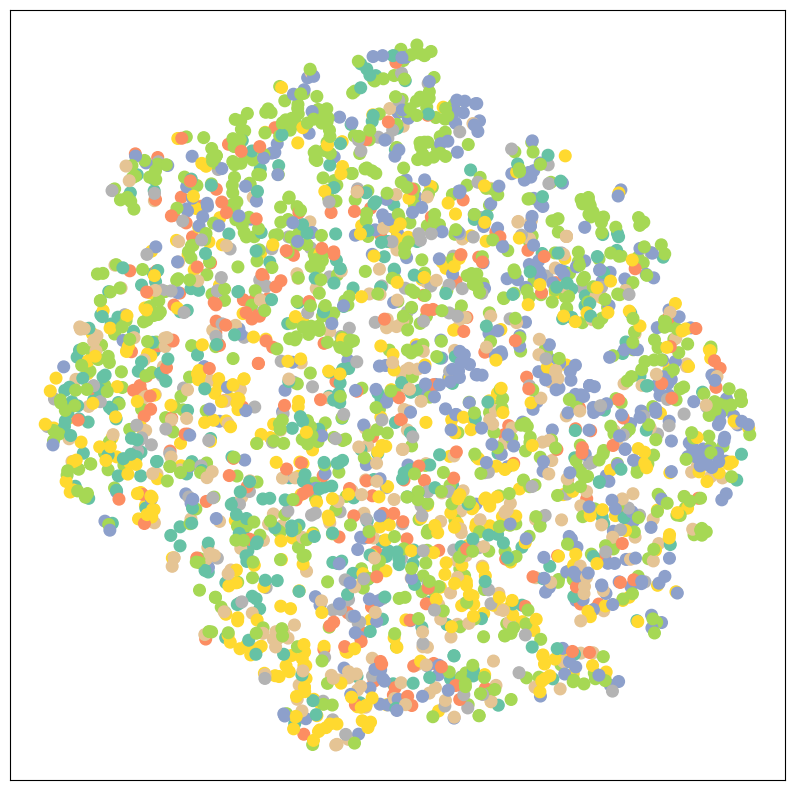

In [12]:
model = GNNModel(HIDDEN_SIZE, NUM_LAYERS)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

There is not much we can say for the moment, the classes are not very distinct. Now, we train the model under the same training condition used for the MLP and repeat this test afterward.

In [13]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 100})'''))

model = GNNModel(HIDDEN_SIZE, NUM_LAYERS)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
      model.train()
      optimizer.zero_grad()
      # We now give as input also the graph connectivity
      out = model(data.x, gso_index, gso_weight)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test(mask):
      model.eval()
      out = model(data.x, gso_index, gso_weight)
      pred = out.argmax(dim=1)
      test_correct = pred[mask] == data.y[mask]
      test_acc = int(test_correct.sum()) / int(mask.sum())
      return test_acc

for epoch in range(1, 201):
    train_loss = train()
    val_loss = test(data.val_mask)
    print(f'Epoch: {epoch:03d} - Training loss: {train_loss:.4f} - '
          f'Validation accuracy: {val_loss * 100:.2f}%')

<IPython.core.display.Javascript object>

Epoch: 001 - Training loss: 1.9629 - Validation accuracy: 7.20%
Epoch: 002 - Training loss: 1.9437 - Validation accuracy: 7.80%
Epoch: 003 - Training loss: 1.9246 - Validation accuracy: 34.00%
Epoch: 004 - Training loss: 1.9034 - Validation accuracy: 34.40%
Epoch: 005 - Training loss: 1.8792 - Validation accuracy: 48.40%
Epoch: 006 - Training loss: 1.8510 - Validation accuracy: 32.80%
Epoch: 007 - Training loss: 1.8180 - Validation accuracy: 25.60%
Epoch: 008 - Training loss: 1.7790 - Validation accuracy: 27.60%
Epoch: 009 - Training loss: 1.7328 - Validation accuracy: 35.00%
Epoch: 010 - Training loss: 1.6787 - Validation accuracy: 44.00%
Epoch: 011 - Training loss: 1.6165 - Validation accuracy: 54.40%
Epoch: 012 - Training loss: 1.5472 - Validation accuracy: 60.20%
Epoch: 013 - Training loss: 1.4719 - Validation accuracy: 63.60%
Epoch: 014 - Training loss: 1.3921 - Validation accuracy: 65.80%
Epoch: 015 - Training loss: 1.3085 - Validation accuracy: 68.40%
Epoch: 016 - Training loss:

In [14]:
test_acc = test(data.test_mask)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

Test Accuracy: 77.20%


Cool! It seems we were able to increase classification accuracy up to **77%**! However, well-designed GNNs can do [even better](https://paperswithcode.com/sota/node-classification-on-cora). Let's check again the model output.

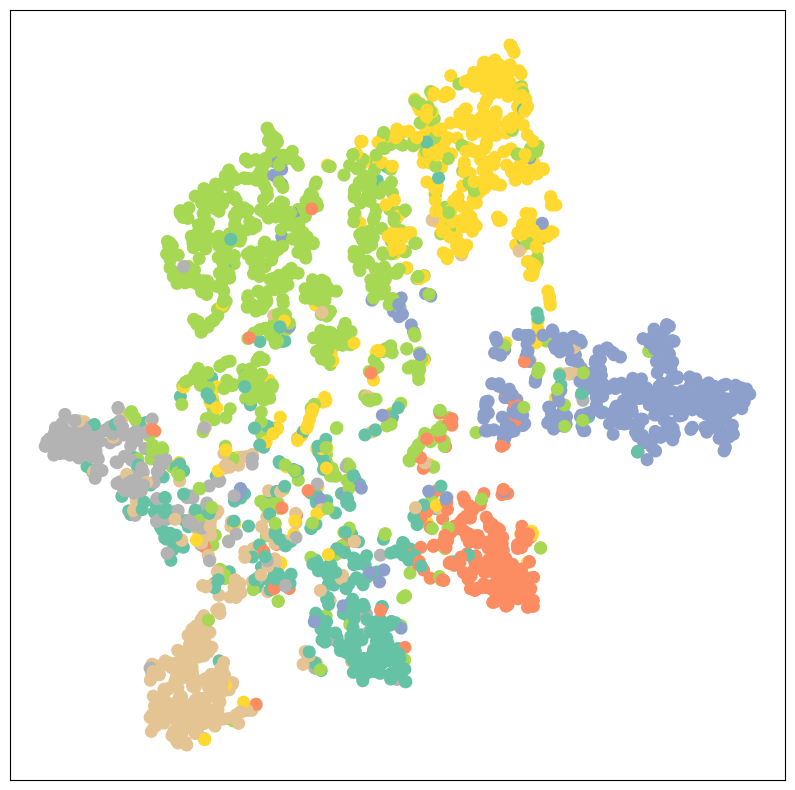

In [15]:
out = model(data.x, data.edge_index)
visualize(out, color=data.y)

Nice, we can now distinguish the 7 classes in a sharper way.

## Conclusion

In this notebook, we have seen how to implement a GNN with a custom message-passing layer for node classification in PyTorch Geometric.


## Credits

*   Colab notebooks [[1]](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8) [[2]](https://colab.research.google.com/drive/14OvFnAXggxB8vM4e8vSURUp1TaKnovzX) from [PyG](https://pyg.org)
* [PyG documentation](https://pytorch-geometric.readthedocs.io/en/latest/tutorial/create_gnn.html)

